# Affinity Propagation - 相似性傳播分群
```
1. 看了公式仍然無法理解..., 發明人論文: http://www.psi.toronto.edu/affinitypropagation/FreyDueckScience07.pdf, 對岸解釋得很清楚但卻又沒法理解的文章: https://read01.com/388am.html, 有人看懂記得分享...
2. 不需要事先指定群數, 每一次跑的分群結果都會一樣(分群穩定性高), 但是效能奇差無比!
3. 應用: 圖像(人臉)辨識, text, 搜索最短路徑... 等等, 算是一般性都可使用, 但是個人測試簡單2維分群(DBSCAN的分法), 卻是爛到不行, 連的很近的資料點也應是分開到不同群
4. 參考資料: http://www.dataivy.cn/blog/%E8%81%9A%E7%B1%BB%E7%AE%97%E6%B3%95affinity-propagation_ap/
            https://read01.com/388am.html
            http://www.psi.toronto.edu/affinitypropagation/FreyDueckScience07.pdf
```

In [2]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# 抓出頻果新聞資料
apple78Df = None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
apple78Df

,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...


In [6]:
# 雖然分了13群跟原始資料群數一樣, 可是效果仍然不好
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import cosine_distances

vec = TfidfVectorizer()
termMx = vec.fit_transform(apple78Df[:1000].term).toarray()
distMx = cosine_distances(termMx)
clf = AffinityPropagation(affinity='precomputed').fit(distMx)
pd.Series(clf.labels_).value_counts()

11    155
1     153
0     137
9      99
8      75
5      72
7      63
6      60
10     50
2      43
12     34
4      34
3      25
dtype: int64

In [7]:
# 設定grp後可觀察分群的狀況
grp = 0
pre1000 = apple78Df[:1000]
print(pre1000[(clf.labels_ == grp)].forum.value_counts())
pre1000[(clf.labels_ == grp)] # & (pre1000.forum == '3c')

international    21
sports           20
entertainment    20
life             16
local            13
finance          12
animal            9
politics          8
fashion           8
strange           7
property          1
3c                1
forum             1
Name: forum, dtype: int64


,forum,subject,term,keyword,content,pageurl
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...
22,entertainment,劉品言甩肉11公斤 胸圍降2級更美,劉品言 言言 出道 感覺 身高 公分 瘦身 代言 時間 代言 產品 食物 控制 天天 健身 ...,言言 言言 言言 言言 言言 言言 言言 修杰楷 修杰楷 修杰楷 修杰楷 劉品言 劉品言 劉...,劉品言（言言）2002年14歲出道至今，給人感覺就是肉肉的，因身高169公分，常有種虎背熊腰...,http://www.appledaily.com.tw/realtimenews/arti...
23,entertainment,NONO環球影城驚魂 老婆朱海君嚇到飆淚,台語 歌手 朱海君 推出 專輯 春花 新加坡 天工 雨神 跟隨 雨淋 環球 影城 變形金剛 ...,朱海君 朱海君 朱海君 朱海君 女兒 女兒 女兒 女兒 女兒 女兒 nono nono 環球...,台語歌手朱海君將推出新專輯《望露的春花》，她趕在發片前的空檔，帶愛女NO妹去新加坡玩，沒想到...,http://www.appledaily.com.tw/realtimenews/arti...
25,fashion,龍后整身Dior 替雜誌大方曬美胸,影集 一角 知名度 英國 女星 克拉克 Emilia Clarke BAZAAR 封面 高級...,emilia emilia emilia emilia bazaar bazaar baza...,以影集《冰與火之歌》龍后一角知名度大開的英國女星艾蜜莉亞克拉克（Emilia Clarke）...,http://www.appledaily.com.tw/realtimenews/arti...
26,fashion,【冒險風】FolliFollie非洲草原遊 大象華麗入飾品,熱帶 時尚 品牌 靈感 來源 浪漫 希臘 品牌 年度 系列 曝光 熱帶 元素 非洲 草原 熱...,系列 系列 系列 系列 系列 系列 系列 系列 系列 系列 系列 系列 系列 kk kk k...,熱帶風情是今年許多時尚品牌的靈感來源，浪漫的希臘飾品品牌Folli Follie也不例外。年...,http://www.appledaily.com.tw/realtimenews/arti...
27,entertainment,阿喜與JR合唱公益EP 募15萬助弱勢,JR 紀言愷 阿喜 推出 合唱 公益 擁抱 好友 蔣卓嘉 阿喜 JR 填詞 銷售 所得 忠義...,jr jr jr jr jr 阿喜 阿喜 阿喜 阿喜 忠義 忠義 擁抱 擁抱 mv mv 公...,JR(紀言愷)和阿喜推出合唱公益EP《你的擁抱》，由好友蔣卓嘉譜曲，阿喜和JR共同填詞，銷售...,http://www.appledaily.com.tw/realtimenews/arti...
28,entertainment,張韶涵升格當導演 拍MV主動加吻戲,張韶涵 推出 專輯 淪陷 音樂 升格 MV 導演 MV 再見 負責 MV 劇情 原創 劇情 ...,張韶涵 張韶涵 張韶涵 張韶涵 張韶涵 mv mv mv mv mv mv 音樂 音樂 音樂...,張韶涵7月21日將推出新專輯《全面淪陷》，她不僅擔任音樂總監，還升格擔任MV導演，交出首支執...,http://www.appledaily.com.tw/realtimenews/arti...
29,entertainment,【百無禁忌】吳慷仁好膽躺冰櫃 特別在意死樣子,吳慷仁 劇場 戀愛 沙塵暴 姊姊 業務員 劇情 冰櫃 屍體 紅包 無所謂 禁忌 吳慷仁 屍體...,冰櫃 冰櫃 冰櫃 冰櫃 吳慷仁 吳慷仁 吳慷仁 屍體 屍體 屍體 劇場 劇場 禁忌 禁忌 星...,吳慷仁拍王小棣植劇場《戀愛沙塵暴》，演個深受姊姊們歡迎的業務員，因劇情需要他得躺進裝死人的冰...,http://www.appledaily.com.tw/realtimenews/arti...


In [23]:
from sklearn.metrics import accuracy_score, make_scorer
help(make_scorer)

Help on function make_scorer in module sklearn.metrics.scorer:

make_scorer(score_func, greater_is_better=True, needs_proba=False, needs_threshold=False, **kwargs)
    Make a scorer from a performance metric or loss function.
    
    This factory function wraps scoring functions for use in GridSearchCV
    and cross_val_score. It takes a score function, such as ``accuracy_score``,
    ``mean_squared_error``, ``adjusted_rand_index`` or ``average_precision``
    and returns a callable that scores an estimator's output.
    
    Read more in the :ref:`User Guide <scoring>`.
    
    Parameters
    ----------
    score_func : callable,
        Score function (or loss function) with signature
        ``score_func(y, y_pred, **kwargs)``.
    
    greater_is_better : boolean, default=True
        Whether score_func is a score function (default), meaning high is good,
        or a loss function, meaning low is good. In the latter case, the
        scorer object will sign-flip the outcome of t

In [24]:
# 用 GridSearchCV tune AffinityPropagation的參數: preference, damping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

accuracyScorer = make_scorer(accuracy_score)
tunedParams = {'preference': np.linspace(-40, 40, 20)}
clf = GridSearchCV(AffinityPropagation(), tunedParams, cv=5, scoring=accuracyScorer)
clf.fit(X, labels_true)

# 結果用 GridSearchCV 找出最佳參數之後 還是分得很爛, 這個在POI幾何使用上可能不太行
print(clf.best_params_)

{u'preference': -23.157894736842106}


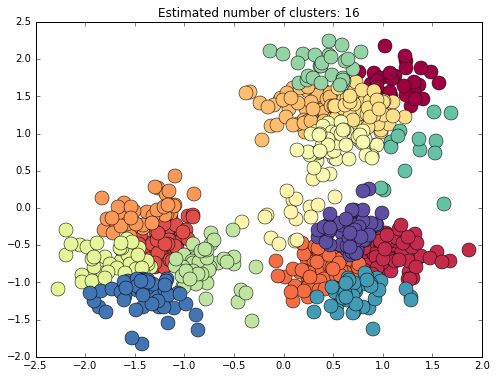

In [43]:
# 仿照DBSCAN的例子產生一樣的資料分群看看

from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)
clf = AffinityPropagation()
clf.fit(X)
labels = clf.labels_

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % len(unique_labels))
plt.show()

Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.
Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


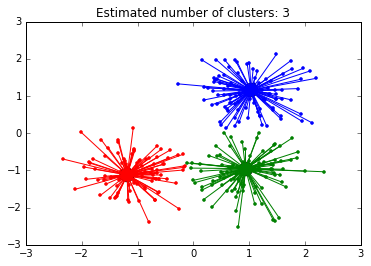

In [6]:
# 官網範例

print(__doc__)

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

##############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

##############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

##############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [44]:
# 仿照DBSCAN的例子產生一樣的資料分群看看

from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)
clf = SpectralClustering(3)
clf.fit(X)
labels = clf.labels_

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % 3)
plt.show()

NameError: name 'SpectralClustering' is not defined